In [5]:
import os
import sys
import time

import GCode
import GRBL
import matplotlib.pyplot as plt
import numpy as np
#import ushr.coord.homogeneous as h
import seaborn as sns

All units in mm. ```1``` = ```1 mm```.

In [7]:
def init():
    program = GCode.GCode()
    program.G0(F=500)
    program.G1(F=300)
    program.M3(S=1)
    program.G28()
    program.G21()  # Metric Units
    program.G90()  # Absolute positioning.
    program.G92(X=0, Y=0)
    program.M5()
    return program


def end():
    program = GCode.GCode()
    program.M5()
    program.G28()
    return program


In [8]:
# Poplar 1x4". Cut
BlockHeight = 89.0  # mm
BlockLength = 2 * BlockHeight  # mm


In [9]:
x0 = 10
y0 = BlockHeight / 2


In [10]:
prog = GCode.GCode()
prog += init()
# Draw Axes
prog += GCode.Line(points=np.array([[x0, 0], [x0, BlockHeight]]), power=50)
prog += GCode.Line(points=np.array([[0, y0], [BlockLength, y0]]), power=50)


In [11]:
cycles = 1
total_distance = BlockLength - 10  # [mm]
wave_length = total_distance / cycles  # [mm]
amplitude = BlockHeight / 4
x = np.arange(0, total_distance, 10)
y = amplitude * np.sin(2 * np.pi * x / wave_length)


In [12]:
%matplotlib inlinesns.set()

KeyError: 'inlinesns.set()'

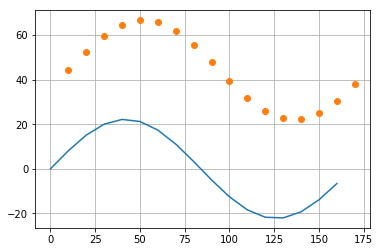

In [13]:
X = x + x0
Y = y + y0

fig, (ax1) = plt.subplots(1, 1)
ax1.grid(True)
ax1.plot(x, y, X, Y, "o")


In [14]:
def circle(center_x=10, center_y=10, radius=10, laser_pwm=255, clockwise=True):
    prog = GCode.GCode()
    prog.G0(X=(center_x - radius), Y=(center_y))
    prog.M3(S=laser_pwm)
    arc_cfg={
        "X": (center_x - radius),
        "Y": (center_y),
        "I": radius,
        "J": 0,      
    }
    if clockwise:
        prog.G2(**arc_cfg)
    else:
        prog.G3(**arc_cfg)
    prog.M5()
    return prog

In [21]:
# Lasers Down
prog.M3(S=0)
prog.M5()
# Jog.
prog.G0(X=X[0], Y=Y[0])
# Lasers Up
prog.M3(S=255)
# Plot the Sine.
for idx, (x, y) in enumerate(zip(X, Y)):
    clockwise=bool(idx%2 == 0)
    prog+=circle(center_x=x, center_y=y, radius=5, clockwise=True)
# Lasers Down.
prog.M3(S=0)
prog.M5()
# Go home.
prog.G28()


In [23]:
from time import sleep

In [24]:
cnc = GRBL.GRBL(port="/dev/cnc_3018")
sleep(0.5)
cnc.laser_mode = 1
sleep(0.5)
print("Laser Mode: {}".format(cnc.laser_mode))
cnc.home()

ok
Laser Mode: 1.0


29

In [25]:
prog.machine=cnc

In [26]:
prog.run()